In [1]:
#Part 1: Station Metadata

In [2]:
import time
from io import BytesIO
import subprocess
import os
import re
import pandas as pd
from zipfile import ZipFile
from pyspark.sql.functions import col, expr, row_number, udf, corr
import station_pb2_grpc, station_pb2, grpc
from pyspark.sql.types import StringType, FloatType
import matplotlib.pyplot as plt

from cassandra.cluster import Cluster
try:
    cluster = Cluster(['project-5-nateproject5-db-1', 'project-5-nateproject5-db-2', 'project-5-nateproject5-db-3'])
    session = cluster.connect()
except Exception as e:
    print(e)

In [3]:
session.execute("""
DROP KEYSPACE IF EXISTS weather;
""")

In [4]:
#create a weather keyspace with 3x replication
session.execute("""
CREATE KEYSPACE IF NOT EXISTS weather 
   WITH REPLICATION = { 
      'class' : 'SimpleStrategy', 
      'replication_factor' : 3 
      } 
""")

In [5]:
#inside weather, create a station_record type containing two ints: tmin and tmax
session.execute("""
CREATE TYPE weather.station_record (
  tmin int,
  tmax int
);
""")

In [6]:
# inside weather, create a stations table
# have four columns: id (text), name (text), date (date), record (weather.station_record)
# id is a partition key and corresponds to a station's ID
# date is a cluster key, ascending
# name is a static field
# record is a regular field because there will be many records per station partition
session.execute("""
CREATE TABLE weather.stations (
    id text,
    name text STATIC,
    date date,
    record weather.station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
""")

In [7]:
#Q1: what is the schema?
print(session.execute("describe keyspace weather").one().create_statement)
print()
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;

CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOCKING'
 

In [8]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8216cdef-c2ae-4446-bc1f-2cfdd0d1549c;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [9]:
#Download https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt
if not os.path.exists("ghcnd-stations.txt"):
    !wget https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt
else:
    print("ghcnd-stations.txt already downloaded")
    
df = spark.read.text("ghcnd-stations.txt")
#parse the data and insert metadata for every station that belongs to Wisconsin WI (id and name columns only) 
#into weather.stations
for i in df.collect():
    if( "WI" in i[0][38:40]):
        id_value = "\'" + i[0][:11] + "\'"
        name_value = "\'" + re.findall(r'[A-Z\s]+', i[0][40:])[0] + "\'"
        session.execute(f"""
            INSERT INTO weather.stations
            (id, name)
            VALUES
            ({id_value}, {name_value})
        """)

ghcnd-stations.txt already downloaded


In [10]:
#Q2: what is the token of the vnode that comes first after the partition for the USC00470273 sensor?

#Use check_output to run nodetool ring and print the output.
result = subprocess.check_output(['nodetool', 'ring', 'weather'], encoding="utf-8")
print(result)

#Use the token(????) CQL function to get the token for the sensor.
row_token = int(pd.DataFrame(
    session.execute("""
        SELECT id, TOKEN(id) 
        FROM weather.stations
        WHERE id='USC00470273';
    """)
)["system_token_id"][0])

#Write some code to loop over the ring and find the correct vnode.
result_list = result.split("\n")
vnode_token = 0

for i in range(3):
    result_list.pop(0)
vnodes = pd.DataFrame(result_list)

for row in vnodes.iterrows():
    if len(row[-1][0].split()) > 1 and row[-1][0].split()[-1] == "Token":
        continue
    elif len(row[-1][0].split()) >= 1:
        vnode = int(row[1][0].split()[-1])
        if row_token <= vnode and vnode_token == 0:
            vnode_token = vnode
        elif row_token <= vnode and vnode_token > vnode:
            vnode_token = vnode
    else:
        break

print("row token: " + str(row_token))
print("vnode token: " + str(vnode_token))


Datacenter: datacenter1
Address          Rack        Status State   Load            Owns                Token                                       
                                                                                8771375606634342024                         
172.21.0.2       rack1       Up     Normal  151.77 KiB      100.00%             -9119652977182356367                        
172.21.0.3       rack1       Up     Normal  151.33 KiB      100.00%             -9006865905401760604                        
172.21.0.4       rack1       Up     Normal  156.39 KiB      100.00%             -8579326566840271302                        
172.21.0.3       rack1       Up     Normal  151.33 KiB      100.00%             -8162489257910598846                        
172.21.0.2       rack1       Up     Normal  151.77 KiB      100.00%             -7529648424668457729                        
172.21.0.4       rack1       Up     Normal  156.39 KiB      100.00%             -7488029456148059042

In [11]:
#Part 2: Temperature Data

In [12]:
#download data for all WI stations
if not os.path.exists("wi-stations.zip"):
    !wget https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip
else:
    print("wi-stations.zip already downloaded")

wi-stations.zip already downloaded


In [13]:
#get ip of vm running server.py
with open('server_container_id.txt', 'r') as file:
    ip = file.read().strip()
port = 5440
addr = f"{ip}:{port}"
channel = grpc.insecure_channel(addr)
stub = station_pb2_grpc.StationStub(channel)

# install pandas 1.5.3 so that spark.createDataFrame() will work with spark version being used
result = subprocess.check_output(['pip', 'show', 'pandas'], encoding="utf-8")
if "Version: 1.5.3" not in result:
    %pip install -U pandas==1.5.3
    print()
    print("restart and run all cells required to continue")

def simulate_sensor(station):
    # loop over tmin/tmax data for every day of 2022 for the given station;
    with ZipFile('wi-stations.zip', 'r') as zf:
        for file in zf.namelist():
            if station in file:
                with zf.open(file, 'r') as f:
                    pdf = pd.read_csv(f, compression='gzip', header=None).drop(columns=[4, 5, 6, 7], axis=1)
                    pdf.columns = ["id", "date", "temps", "value"]
                    sdf = (spark.createDataFrame(pdf)
                           .withColumn("value", col("value").cast("Int"))
                           .withColumn("date", col("date").cast("String"))
                           .withColumn("temps", col("temps").cast("String"))
                          )
                    dates_pdf = (sdf.select("date", "value", "temps")
                                .where(expr("substring(date, 0, 4)=2022"))
                                .groupby("date")
                                .pivot("temps", ["TMIN", "TMAX"])
                                .agg(expr("first(value)"))
                                ).toPandas()
                                #OFFICE HOURS HELPER CODE FROM TA:
                                #df.where("date between '20220101' and '20221231'")
                                #             .groupby(["station", "date"])
                                #             .pivot("element", ["TMIN", "TMAX"])
                                #             .agg(expr("first(value)"))
                                #             .sort("date")).collect()
                    for _, row in dates_pdf.iterrows():
                        date = str(row["date"])
                        #convert to yyyy-mm-dd
                        formattedDate = date[:4] + "-" + date[4:6] + "-" + date[6:]
                        tmax = int(row["TMAX"])
                        tmin = int(row["TMIN"])
                        # send each to server with RecordTemps call
                        resp = stub.RecordTemps(station_pb2.RecordTempsRequest(station=station, date=formattedDate, tmin=tmin, tmax=tmax))
                        if resp.error:
                            print(r.error)
                            assert False

for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

/tmp/ipykernel_1025/2978889804.py:22: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf = pd.read_csv(f, compression='gzip', header=None).drop(columns=[4, 5, 6, 7], axis=1)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/04/17 07:34:38 WARN TaskSetManager: Stage 1 contains a task of very large size (3055 KiB). The maximum recommended task size is 1000 KiB.


max temp for USW00014837 is 356


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


max temp for USR0000WDDG is 344


/tmp/ipykernel_1025/2978889804.py:22: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf = pd.read_csv(f, compression='gzip', header=None).drop(columns=[4, 5, 6, 7], axis=1)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/04/17 07:35:19 WARN TaskSetManager: Stage 13 contains a task of very large size (3688 KiB). The maximum recommended task size is 1000 KiB.


max temp for USW00014898 is 356


/tmp/ipykernel_1025/2978889804.py:22: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf = pd.read_csv(f, compression='gzip', header=None).drop(columns=[4, 5, 6, 7], axis=1)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/04/17 07:35:44 WARN TaskSetManager: Stage 19 contains a task of very large size (3091 KiB). The maximum recommended task size is 1000 KiB.


max temp for USW00014839 is 378


In [14]:
#Part 3: Spark Analysis

In [15]:
#Configured your Spark session so such that spark.table("cassandra.weather.stations") 
#gives you access to the table in Cassandra
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-nateproject5-db-1:9042")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-nateproject5-db-2:9042")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-nateproject5-db-3:9042")

In [16]:
#Create a view called weather2022 that contains all 2022 data from cassandra.weather.stations
spark.table("cassandra.weather.stations").where(expr("date BETWEEN '2022-01-01' AND '2022-12-31'"))\
.createOrReplaceTempView("weather2022")
spark.sql("show tables").show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |weather2022|       true|
+---------+-----------+-----------+



In [17]:
#Cache weather2022
weather2022 = spark.table("weather2022")
weather2022.cache()

DataFrame[id: string, date: date, record: struct<tmin:int,tmax:int>, name: string]

In [18]:
#Register a UDF (user-defined function) that takes a TMIN or TMAX number and returns Fahrenheit
def converter(int):
    # code from piazza post @466: https://piazza.com/class/lcupsjme6oh4gw/post/466
    return (float(int) * .18) + 32
celciusToFahrenheit = udf(lambda c: converter(c), FloatType())
spark.udf.register("celciusToFahrenheit", celciusToFahrenheit)

<function __main__.<lambda>(c)>

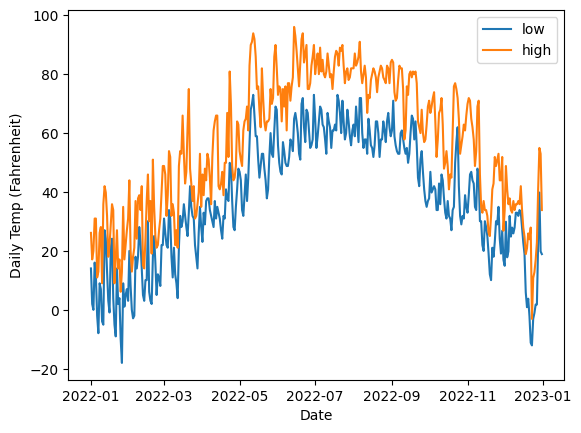

In [19]:
#Q3: what were the daily highs and lows at Madison's airport in 2022?
data = (weather2022
        .withColumn("tmin", celciusToFahrenheit("record.tmin"))
        .withColumn("tmax", celciusToFahrenheit("record.tmax"))
        .select("date", "tmin", "tmax")
        .where(expr("id='USW00014837'"))
       ).toPandas()

data = data.set_index("date")
plt.plot(data['tmin'], label='low')
plt.plot(data['tmax'], label='high')
plt.ylabel('Daily Temp (Fahrenheit)')
plt.xlabel('Date')
plt.legend()

In [20]:
#Q4: what is the correlation between maximum temperatures in Madison and Milwaukee?

milwaukee = weather2022.select("record.tmax").where(expr("id='USW00014839'")).toPandas()
madison = weather2022.select("record.tmax").where(expr("id='USW00014837'")).toPandas()
Mad_Mil = pd.DataFrame()
Mad_Mil["madison_tmax"] = pd.Series(madison["tmax"])
Mad_Mil["milwaukee_tmax"] = pd.Series(milwaukee["tmax"])
correlation = spark.createDataFrame(Mad_Mil)
correlation.agg(corr("madison_tmax", "milwaukee_tmax").alias('correlation')).collect()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


[Row(correlation=0.9786907979650685)]

In [21]:
#Part 4: Disaster Strikes
print("stop the notebook and kill container not running jupyter or server.py, then run the next cell")
time.sleep(999999)

stop the notebook and kill container not running jupyter or server.py, then run the next cell


KeyboardInterrupt: 

In [22]:
#Q5: does StationMax still work?
r = stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))
if r.error:
    print(r.error)
else:
    print(f"max temp for {station} is {r.tmax}")

23/04/17 07:39:39 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=05aa0683-4d6b-418c-bfae-845aa372d377, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681716834760}): failed to send request (java.nio.channels.NotYetConnectedException))


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: bad argument type for built-in operation"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:172.21.0.4:5440 {created_time:"2023-04-17T07:39:43.790691695+00:00", grpc_status:2, grpc_message:"Exception calling application: bad argument type for built-in operation"}"
>

In [23]:
#Q6: does simulate_sensor still work?
simulate_sensor("USC00477115")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/04/17 07:39:55 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=05aa0683-4d6b-418c-bfae-845aa372d377, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681716834760}): failed to send request (java.nio.channels.NotYetConnectedException))


In [24]:
#Q7: how does refreshing the stale cache change the number of rows in weather2022?
print("BEFORE REFRESH: ", weather2022.select(expr("COUNT(record) as rows")).collect())
spark.sql("REFRESH TABLE weather2022")
print("AFTER REFRESH: ", weather2022.select(expr("COUNT(record) as rows")).collect())

BEFORE REFRESH:  [Row(rows=1460)]


AFTER REFRESH:  [Row(rows=1825)]
